### Data Prepraing & Splitting

In [1]:
import pandas as pd
import sklearn
import joblib
import numpy as np
import matplotlib.pyplot as plt

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# pd.set_option('display.max_columns',None)
# sklearn.set_config(transform_output='pandas')

In [3]:
tr_df=pd.read_csv('data/train.csv')
val_df=pd.read_csv('data/val.csv')
te_df=pd.read_csv('data/test.csv')

In [4]:
te_df.head()

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Multiple Carriers,2019-03-03,Delhi,Cochin,18:15:00,01:35:00,440,1.0,No Info,18916
1,Jet Airways,2019-06-01,Delhi,Cochin,20:55:00,12:35:00,940,1.0,In-flight meal not included,10262
2,Multiple Carriers,2019-06-06,Delhi,Cochin,07:05:00,16:10:00,545,1.0,No Info,9646
3,Air India,2019-03-24,Kolkata,Banglore,16:50:00,18:30:00,1540,1.0,No Info,14641
4,Multiple Carriers,2019-05-27,Delhi,Cochin,10:20:00,19:00:00,520,1.0,No Info,9794


In [5]:
def split_data(df):
    X=df.drop(columns='price')
    y=df['price']
    return X,y

In [6]:
X_train,y_train = split_data(tr_df)

In [7]:
print(X_train.shape, y_train.shape)

(640, 9) (640,)


In [8]:
X_val,y_val = split_data(val_df)
X_test,y_test = split_data(te_df)

In [9]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          640 non-null    object 
 1   date_of_journey  640 non-null    object 
 2   source           640 non-null    object 
 3   destination      640 non-null    object 
 4   dep_time         640 non-null    object 
 5   arrival_time     640 non-null    object 
 6   duration         640 non-null    int64  
 7   total_stops      640 non-null    float64
 8   additional_info  640 non-null    object 
dtypes: float64(1), int64(1), object(7)
memory usage: 45.1+ KB


### Data Preprocessing

In [10]:
dt_cols = ['date_of_journey','dep_time','arrival_time']
num_cols = X_train.select_dtypes(include=['number']).columns.tolist()
cat_cols = [col for col in X_train.columns if (col not in num_cols) and (col not in dt_cols)]

In [11]:
num_cols

['duration', 'total_stops']

In [12]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from feature_engine.datetime import DatetimeFeatures

In [13]:
num_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), ('scalar', StandardScaler())])
cat_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')), 
                          ('encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))])

In [14]:
doj_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')), 
         ('extractor', DatetimeFeatures(features_to_extract=['month','week','day_of_month','day_of_week'], format='%Y-%m-%d')),
         ('scalar', StandardScaler())])

time_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')), 
         ('extractor', DatetimeFeatures(features_to_extract=['hour','minute'], format='%H:%M:%S')),
         ('scalar', StandardScaler())])

In [15]:
prepro = ColumnTransformer(transformers=[('num',num_transformer, num_cols), ('cat',cat_transformer, cat_cols),('doj',doj_transformer,['date_of_journey']), 
        ('time',time_transformer,['dep_time','arrival_time'])], remainder='passthrough')

In [16]:
prepro.fit_transform(X_train)

array([[-1.09591823, -1.21213152,  0.        , ..., -0.14005709,
        -0.34523131,  1.49385907],
       [ 1.43569944,  0.31797533,  0.        , ..., -1.22986299,
        -0.93560684,  0.89104078],
       [ 1.82441239,  1.84808218,  0.        , ..., -0.68496004,
        -0.34523131, -1.21882323],
       ...,
       [-0.94641325, -1.21213152,  0.        , ..., -0.95741152,
        -0.78801296,  1.49385907],
       [ 0.18982461,  0.31797533,  0.        , ...,  1.22220029,
         1.1307075 , -1.52023237],
       [ 0.63833955,  0.31797533,  0.        , ..., -1.22986299,
        -0.19763743, -1.52023237]])

### Model Selection

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [18]:
algo = {'Linear Regression':LinearRegression(), 'SVM': SVR(), 
        'Random Forest': RandomForestRegressor(n_estimators=15),
        'XGB': XGBRegressor(n_estimators=15)}

In [19]:
from sklearn.metrics import r2_score
from sklearn.model_selection import learning_curve

In [20]:
data = pd.concat([tr_df,val_df], axis=0)
X_data, y_data = split_data(data)

In [21]:
print(X_data.shape, y_data.shape)

(800, 9) (800,)


In [22]:
def plot(s,msc,stsc, lab, ax):
    ax.plot(s, msc, marker='o', label=lab)
    ax.fill_between(x=s, y1= msc-stsc, y2= msc+stsc, alpha=0.4)

In [23]:
def plot_curve(name,algo,size=(9,5)):
    model = Pipeline(steps=[('pre',prepro), ('alg', algo)])
    tr_sizes, tr_scs, te_scs = learning_curve(estimator=model, X=X_data , y=y_data, cv=4, 
                                              scoring='r2', n_jobs=1, random_state=42)
    mean_tr_scs = np.mean(tr_scs,axis=1)
    std_tr_scs = np.std(tr_scs,axis=1)
    tr_lbl = f'{mean_tr_scs[-1]:.2f} +/- {std_tr_scs[-1]:.2f}'
    
    mean_te_scs = np.mean(te_scs,axis=1)
    std_te_scs = np.std(te_scs,axis=1)
    te_lbl = f'{mean_te_scs[-1]:.2f} +/- {std_te_scs[-1]:.2f}'
    
    fig, ax = plt.subplots(figsize=size,)
    
    #training curve
    plot(tr_sizes, mean_tr_scs, std_tr_scs, f'Train({tr_lbl})',ax)
    #testing curve
    plot(tr_sizes, mean_te_scs, std_te_scs, f'Validation({te_lbl})',ax)
    
    ax.set(xlabel ='Training Set Size', ylabel='R2 Score', title=name)
    ax.legend(loc='lower right')
    plt.show()
    

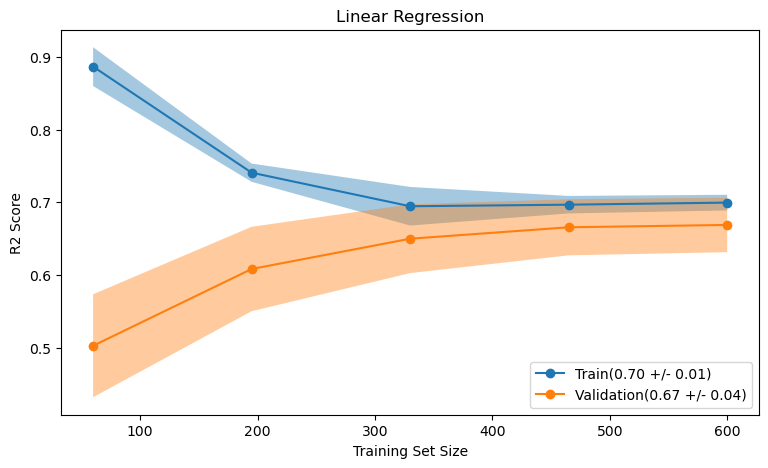

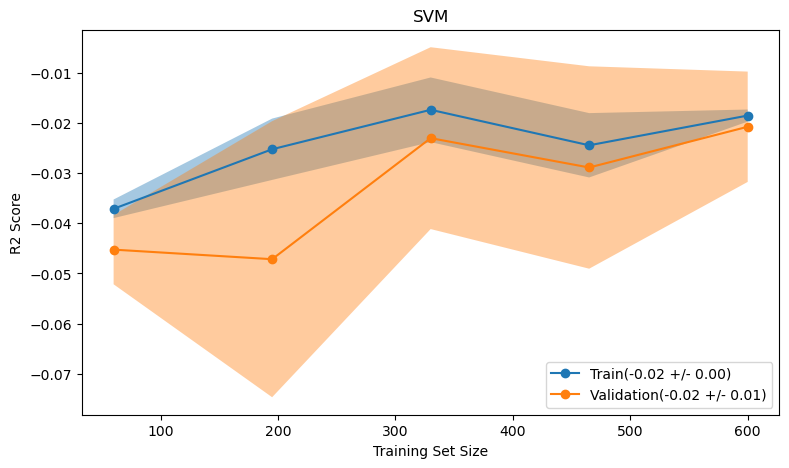

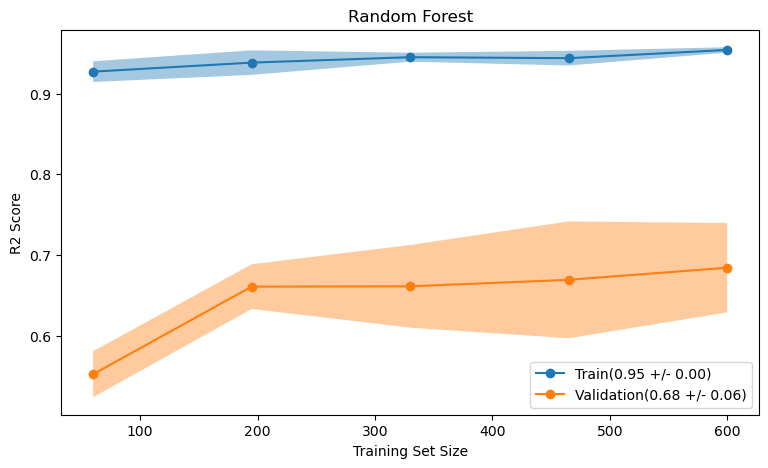

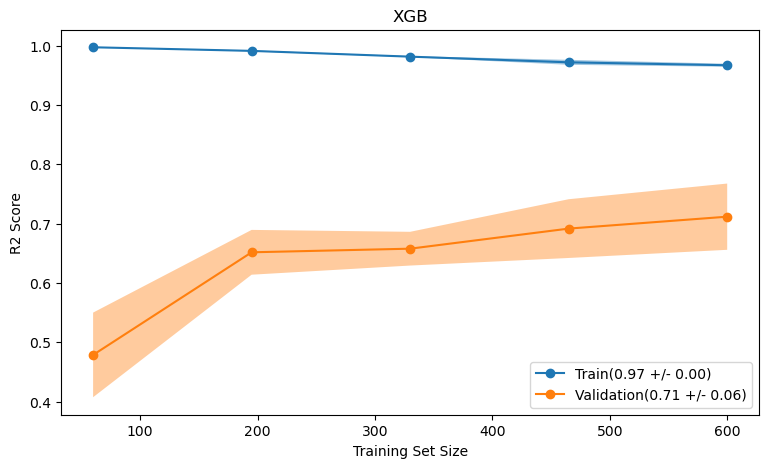

In [24]:
for name, al in algo.items():
    plot_curve(name, al)

### Model Training

In [25]:
model = Pipeline(steps=[("pre", prepro),("XGB", XGBRegressor(n_estimators=15))])

In [26]:
model.fit(X_data,y_data)

Pipeline(steps=[('pre',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scalar',
                                                                   StandardScaler())]),
                                                  ['duration', 'total_stops']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=15, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

### Model Evaluation

In [27]:
def evaluate_model(X, y):
	y_pred = model.predict(X)
	return r2_score(y, y_pred)

In [28]:
print(f"R2 score on Training and Testing data are {evaluate_model(X_data, y_data):.3f} and {evaluate_model(X_test, y_test):.3f} ")

R2 score on Training and Testing data are 0.959 and 0.712 


### Model Persistance

In [29]:
joblib.dump(model, "model.joblib")

['model.joblib']

In [30]:
saved_model = joblib.load("model.joblib")
saved_model

Pipeline(steps=[('pre',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scalar',
                                                                   StandardScaler())]),
                                                  ['duration', 'total_stops']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=15, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])